In [6]:
import h5py
import timeit
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from pylab import *
from matplotlib import cm
from scipy.stats import norm
from scipy.signal import welch
from scipy.signal import csd
from scipy.signal import correlate
from scipy.fft import fft
from scipy.integrate import cumtrapz
from scipy.integrate import romb
from matplotlib.backends.backend_pdf import PdfPages
from tempfile import mkdtemp
import os.path as path
from statistics import mean

plt.style.use('classic')
mpl.rc("figure", facecolor="white")

# Data Import

Change Directory to Compressed Data File Location

In [7]:
exp_name = '4K GEN2HG'

Lock-in amplifier frequencies

In [8]:
f_lockin1 = 4.993017E6
f_lockin2 = 5.505658500E+6 - 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01

In [9]:
data_name = 'run4-HG'

In [10]:
os.chdir('C:/Users/21958742/OneDrive - The University of Western Australia/UNI/PhD/High Frequency GW/Data Analysis/' + exp_name +'/'+data_name)

In [11]:
f=h5py.File(data_name+'-1D.hdf5','r')

In [12]:
list(f.keys())

['Mag', 'Phase', 'X1', 'X2', 'Y1', 'Y2']

In [8]:
channel_1X=f['X1/Data']
channel_1Y=f['Y1/Data']
channel_2X=f['X2/Data']
channel_2Y=f['Y2/Data']

In [13]:
test_size = 10000000
channel_1X=f['X1/Data'][:test_size]
channel_1Y=f['Y1/Data'][:test_size]
channel_2X=f['X2/Data'][:test_size]
channel_2Y=f['Y2/Data'][:test_size]

In [14]:
np.mean(channel_1X)

0.26543477792969167

In [15]:
datasize=len(channel_1X)
nl2 = test_size//256
sc1 = 'density'
fs_rate=100

In [16]:
np.mean(channel_2X)

0.9214291987229627

# PSDs and Strain Sensitivty

In [17]:
f_welch_1X, S_welch_1X = welch(
        (channel_1X), fs=fs_rate, nperseg=nl2, #noverlap=nl1,
        detrend=None, scaling=sc1, window='hanning')


In [18]:
f_welch_1Y, S_welch_1Y = welch(
        (channel_1Y), fs=fs_rate, nperseg=nl2, #noverlap=nl1,
        detrend=None, scaling=sc1, window='hanning')

In [19]:
f_welch_2X, S_welch_2X = welch(
        (channel_2X), fs=fs_rate, nperseg=nl2, #noverlap=nl1,
        detrend=None, scaling=sc1, window='hanning')

In [20]:
f_welch_2Y, S_welch_2Y = welch(
        (channel_2Y), fs=fs_rate, nperseg=nl2, #noverlap=nl1,
        detrend=None, scaling=sc1, window='hanning')

In [21]:
np.mean(np.sqrt(S_welch_2X))

0.15343163595359324

PSD of SQUID Output Voltage

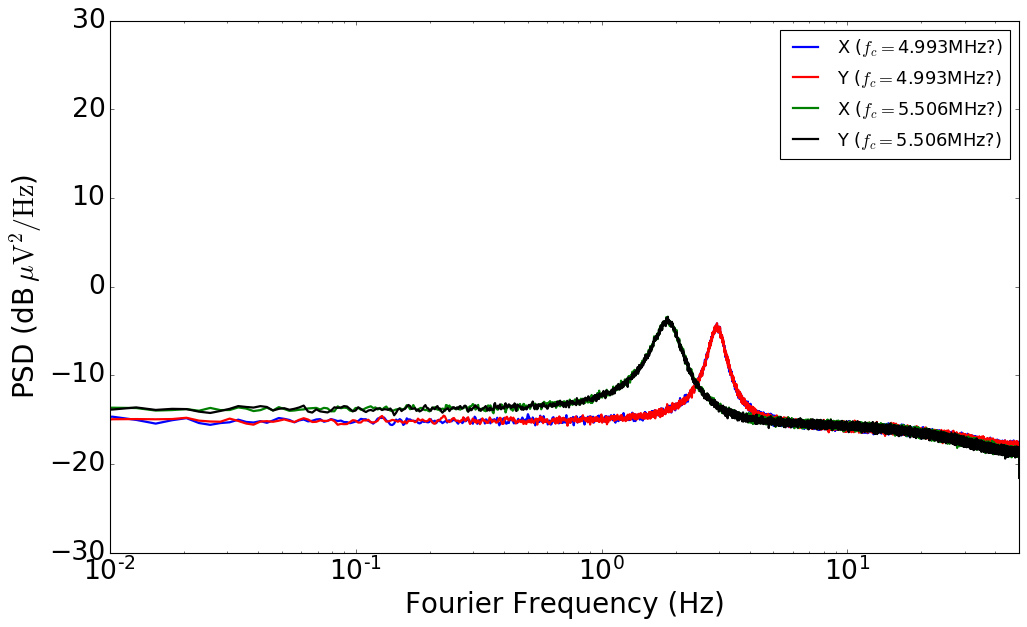

In [22]:

fig, axes = plt.subplots(1,1, figsize=(13,8))
axes.plot(f_welch_1X,10*log10(S_welch_1X), 'b', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz?)")
axes.plot(f_welch_1Y,10*log10(S_welch_1Y), 'r', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz?)")

axes.plot(f_welch_2X,10*log10(S_welch_2X), 'g', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz?)")
axes.plot(f_welch_2Y,10*log10(S_welch_2Y), 'k', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz?)")

axes.legend(loc=0,fontsize=16)

#axes.grid(True)
#axes.grid(True)

axes.set_xscale('log')
#axes.set_yscale('log')
#axes.legend()
plt.xlim(0.01, 50)
#plt.ylim(-20,0)
axes.set_xlabel(r'Fourier Frequency (Hz)', fontsize=25)
axes.set_ylabel(r'PSD (dB$\:\mu\mathrm{V}^2/\mathrm{Hz}$)', fontsize=25)

plt.setp(axes.get_xticklabels(), rotation='horizontal', fontsize=24)
plt.setp(axes.get_yticklabels(), rotation='horizontal', fontsize=24)


fig.tight_layout()

pp = PdfPages('PSD.pdf')
plt.savefig(pp, format='pdf', dpi=300)
pp.close()

In [23]:
f_channel1=f_welch_1X[list(S_welch_1X).index(max(S_welch_1X[3:]))]
f_channel2=f_welch_2Y[list(S_welch_2Y).index(max(S_welch_2Y[3:]))]

In [24]:
f_channel1, f_channel2

(2.94915774921919, 1.8611438226409296)

# Parameters

Need to be updated manually based on which run

In [21]:

fs_rate=100
h0=0.0005
trap=0.848
H0=2.2*10**(-18)

fr1=f_lockin1+f_channel1
omega1=2*np.pi*fr1
omega_ch1=2*np.pi*f_channel1
tau1=Q1/omega1

fr2=f_lockin2+f_channel2
omega2=2*np.pi*fr2
omega_ch2=2*np.pi*f_channel2
tau2=Q2/omega2


In [22]:
Si_1X=(S_welch_1X)*(10**(-6))**2*((1.2*10**6)**(-2))
Si_1Y=(S_welch_1Y)*(10**(-6))**2*((1.2*10**6)**(-2))
Si_2X=(S_welch_2X)*(10**(-6))**2*((1.2*10**6)**(-2))
Si_2Y=(S_welch_2Y)*(10**(-6))**2*((1.2*10**6)**(-2))

In [23]:
np.mean(np.sqrt(Si_2X))

1.2785969662799437e-13

Spectral Displacement Density

In [24]:
Sx_1X=Si_1X*((1/(kappa_1*2*np.pi*(fr1+f_welch_1X))))**2
Sx_1Y=Si_1Y*((1/(kappa_1*2*np.pi*(fr1+f_welch_1Y))))**2
Sx_2X=Si_2X*((1/(kappa_2*2*np.pi*(fr2+f_welch_2X))))**2
Sx_2Y=Si_2Y*((1/(kappa_2*2*np.pi*(fr2+f_welch_2Y))))**2

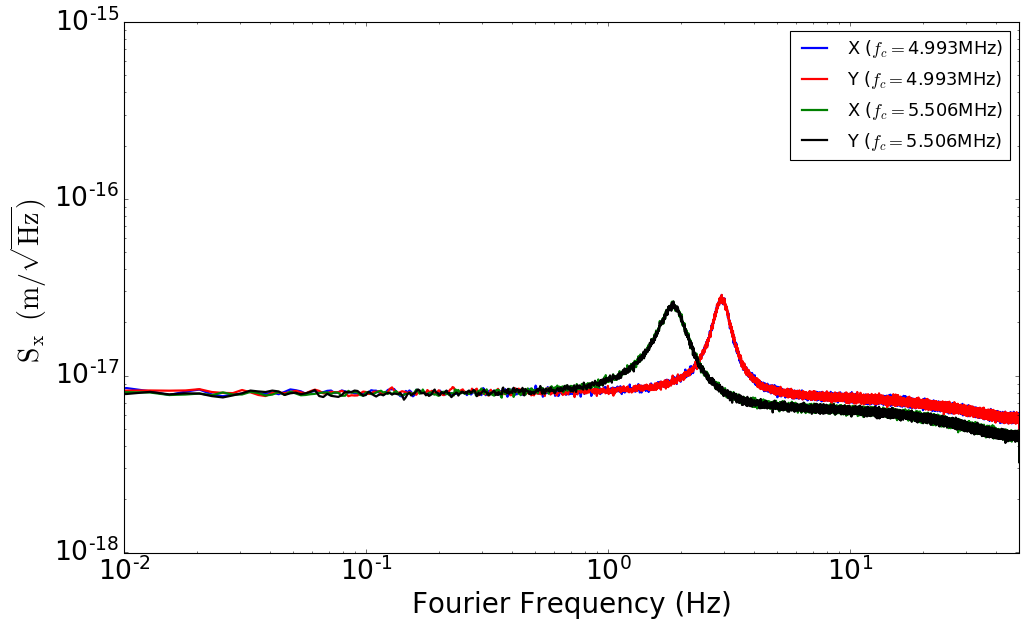

In [25]:
fig, axes = plt.subplots(1,1, figsize=(13,8))
axes.plot(f_welch_1X,np.sqrt(Sx_1X), 'b', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz)")
axes.plot(f_welch_1Y,np.sqrt(Sx_1Y), 'r', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz)")

axes.plot(f_welch_2X,np.sqrt(Sx_2X), 'g', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz)")
axes.plot(f_welch_2Y,np.sqrt(Sx_2Y), 'k', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz)")

axes.legend(loc=0,fontsize=16)

#axes.grid(True)
#axes.grid(True)

axes.set_xscale('log')
axes.set_yscale('log')
#axes.legend()
plt.xlim(0.01,50)
#plt.ylim(10**-17,10**-15)

axes.set_xlabel(r'Fourier Frequency (Hz)', fontsize=25)
axes.set_ylabel(r'  $\mathrm{S_x}\;\;(\mathrm{m}/\sqrt{\mathrm{Hz}})$ ', fontsize=25)

plt.setp(axes.get_xticklabels(), rotation='horizontal', fontsize=24)
plt.setp(axes.get_yticklabels(), rotation='horizontal', fontsize=24)


fig.tight_layout()


Spectral Strain Sensitivty via Transfer Function (See Mathematica Notebook)

Transfer Function

In [26]:
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+omega1**2))
def trans2(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau2+omega2**2))

In [27]:
# converts fft of voltage series to fft of strain series
def voltstodisp_1(x,f):
    Si=(x)*(10**(-6))*((1.2*10**6)**(-1))
    Sx=Si*((1/(k*(f)*1j)))
    return Sx

def voltstodisp_2(x,f):
    Si=(x)*(10**(-6))*((1.2*10**6)**(-1))
    Sx=Si*((1/(k*(f)*1j)))
    return Sx

In [28]:
def voltstodisp_PSD_1(x,f): #converts PSD of voltage series to PSD of strain series
    Si=(x)*(10**(-6))**2*((1.2*10**6)**(-2))
    Sx=Si*((1/(k*(f))))**2
    return Sx

def voltstodisp_PSD_2(x,f): #converts PSD of voltage series to PSD of strain series
    Si=(x)*(10**(-6))**2*((1.2*10**6)**(-2))
    Sx=Si*((1/(k*(f))))**2
    return Sx

In [29]:
Hx_1X=np.array(list(map(trans1,2*np.pi*(f_welch_1X+f_lockin1))))
Hx_1Y=np.array(list(map(trans1,2*np.pi*(f_welch_1Y+f_lockin1))))
Hx_2X=np.array(list(map(trans2,2*np.pi*(f_welch_2X+f_lockin2))))
Hx_2Y=np.array(list(map(trans2,2*np.pi*(f_welch_2Y+f_lockin2))))

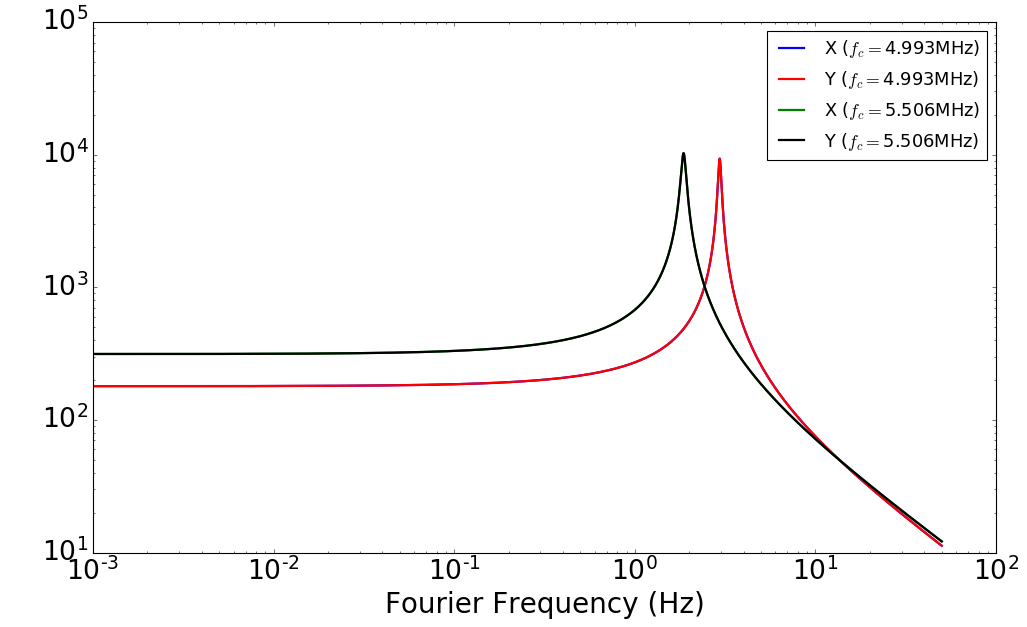

In [30]:
fig, axes = plt.subplots(1,1, figsize=(13,8))
axes.plot(f_welch_1X,Hx_1X, 'b', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz)")
axes.plot(f_welch_1Y,Hx_1Y, 'r', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz)")

axes.plot(f_welch_2X,Hx_2X, 'g', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz)")
axes.plot(f_welch_2Y,Hx_2Y, 'k', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz)")

axes.legend(loc=0,fontsize=16)

#axes.grid(True)
#axes.grid(True)

axes.set_xscale('log')
axes.set_yscale('log')
#axes.legend()
#plt.xlim(1,50)
#plt.ylim(10**-17,10**-15)

axes.set_xlabel(r'Fourier Frequency (Hz)', fontsize=25)
axes.set_ylabel(r'  ', fontsize=25)

plt.setp(axes.get_xticklabels(), rotation='horizontal', fontsize=24)
plt.setp(axes.get_yticklabels(), rotation='horizontal', fontsize=24)


fig.tight_layout()


In [31]:
h_1X=np.sqrt(Sx_1X)/Hx_1X
h_1Y=np.sqrt(Sx_1Y)/Hx_1Y
h_2X=np.sqrt(Sx_2X)/Hx_2X
h_2Y=np.sqrt(Sx_2Y)/Hx_2Y

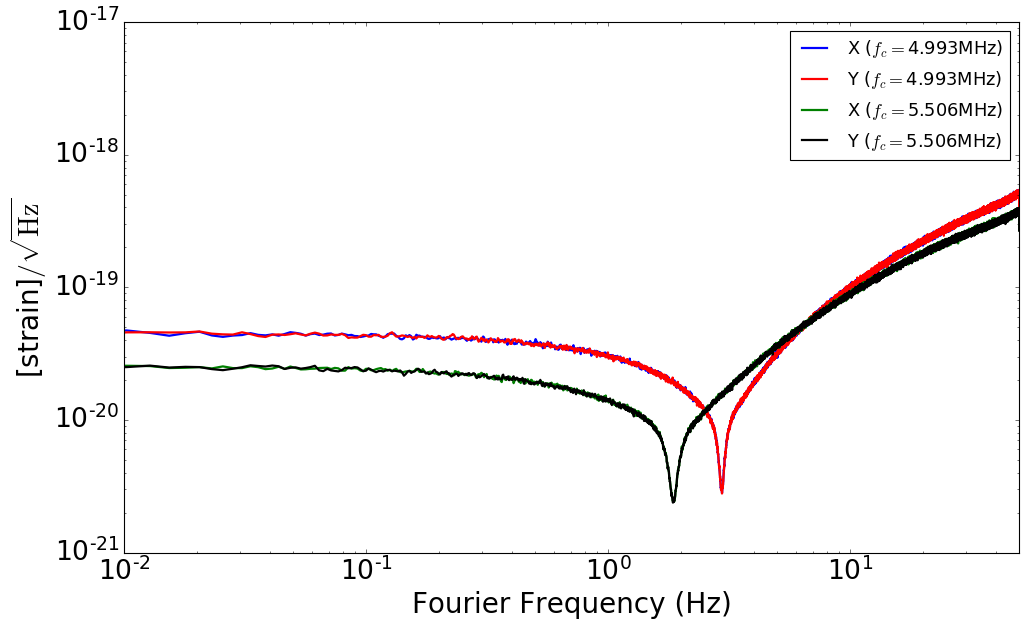

In [34]:
fig, axes = plt.subplots(1,1, figsize=(13,8))
axes.plot(f_welch_1X,h_1X, 'b', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz)")
axes.plot(f_welch_1Y,h_1Y, 'r', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin1/10**6,'1.3f'))+ "MHz)")

axes.plot(f_welch_2X,h_2X, 'g', linewidth=2, label=r"X ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz)")
axes.plot(f_welch_2Y,h_2Y, 'k', linewidth=2, label=r"Y ($f_c = $" +str(format(f_lockin2/10**6,'1.3f'))+ "MHz)")

axes.legend(loc=0,fontsize=16)

#axes.grid(True)
#axes.grid(True)

axes.set_xscale('log')
axes.set_yscale('log')
#axes.legend()
plt.xlim(0.01,50)
#plt.ylim(10**-17,10**-15)

axes.set_xlabel(r'Fourier Frequency (Hz)', fontsize=25)
axes.set_ylabel(r'[strain]$/\sqrt{\mathrm{Hz}}$', fontsize=25)

plt.setp(axes.get_xticklabels(), rotation='horizontal', fontsize=24)
plt.setp(axes.get_yticklabels(), rotation='horizontal', fontsize=24)


fig.tight_layout()

pp = PdfPages('Strain_Sensitivty.pdf')
plt.savefig(pp, format='pdf', dpi=300)
pp.close()

In [140]:
with open(data_name+'-frequencies' + ".out", "w") as text_file:
    msg = "Run name: " + data_name
    text_file.write(msg + "\n")
    print(msg)
    msg = "Channel 1 is at " + str(f_channel1)
    text_file.write(msg +'\n')
    print(msg)
    msg = "channel 2 is at " + str(f_channel2)
    text_file.write(msg + '\n')
    print(msg)

Run name: run4-HG
Channel 1 is at 2.91317671092952
channel 2 is at 1.8835546475995915
